# Media optimal allocation notebook

This notebook present how to optimize media budget allocation.

---

**Reference to modeling approach:** https://www.slideshare.net/koenpauwels/replace-attribution-myths-with-optimal-allocation
![Modeling approach](https://image.slidesharecdn.com/replaceattributionmythswithoptimalallocation-181114002545/95/replace-attribution-myths-with-optimal-allocation-14-1024.jpg)

---

**Data source:** https://www.kaggle.com/regivm/retailtransactiondata

# 0. Setup Environment and Import  

In [0]:
# # Run this code when reset session
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# import subprocess
# !python '/content/gdrive/My Drive/python_projects/{project_name}/colab_setup.py'

In [0]:
# import sys
# sys.path.append('/content/gdrive/My Drive/python_projects/{project_name}')
# %load_ext autoreload
# %autoreload 2

In [0]:
# Upgrade new version of SQLite, run this then reset runtime
# Thanks to this StackOverflow answer: https://stackoverflow.com/a/59429952
%cd
!wget https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release -O sqlite.tar.gz
!tar xzf sqlite.tar.gz
%cd sqlite/
!./configure
!make sqlite3.c
%cd
!npx degit coleifer/pysqlite3 -f
!cp sqlite/sqlite3.[ch] .
!python setup.py build_static build
!cp build/lib.linux-x86_64-3.6/pysqlite3/_sqlite3.cpython-36m-x86_64-linux-gnu.so \
    /usr/lib/python3.6/lib-dynload/_sqlite3.cpython-36m-x86_64-linux-gnu.so

In [0]:
# RFMC framework to quantify customer value
import pandas as pd
from pandas import DataFrame as df
import sqlite3
import matplotlib.pyplot as plt
import math



class SqlDb(object):
    def __init__(self):
        self.con = sqlite3.connect(':memory:')
        self.cur = self.con.cursor()
    
    def create_table(self, table_name, *, data_df):
        self.delete_table(table_name)
        return data_df.to_sql(name = table_name, con = self.con)

    def delete_table(self, table_name):
        return self.cur.execute(f"DROP TABLE IF EXISTS {table_name}")

    def insert_into(self, table_name, *, query_string):
        data_df = self.query(query_string)
        self.create_table(table_name, data_df = data_df)
        return data_df
    
    def query(self, query_string):
        res = self.cur.execute(query_string)
        header = list(map(lambda x: x[0], res.description))
        data = res.fetchall()
        data_df = df(data = data, columns = header)
        data_df.drop(columns=['index'], inplace=True, errors='ignore')
        return data_df



db = SqlDb()
db.con.create_function('log', 2, math.log)

retail_transaction_df = pd.read_csv(
    'https://raw.githubusercontent.com/alexjdata/drive_marketing/master/input/retailtransactiondata_transactions.csv', 
    parse_dates=['trans_date']
)
retail_transaction_df.rename(columns={'tran_amount': 'amount'}, inplace=True)
db.create_table(
    data_df = retail_transaction_df, 
    table_name = 'retail_transaction'
)

In [57]:
sqlite3.sqlite_version

'3.30.1'

# 1. Rank customer by RFMC percentage rank

## 1.1 Rank customer by RFM percentage rank

In [58]:
rfm_rank_df = db.insert_into(
    table_name = 'customer_rfm_rank', 
    query_string = 
    """
    WITH 
        rfm_table AS (
            SELECT 
                customer_id
                , JULIANDAY(MAX(trans_date)) - JULIANDAY('now') as recency
                , COUNT(customer_id) as frequency
                , SUM(amount) as monetary
            FROM retail_transaction
            GROUP BY 
                customer_id
            ORDER BY 
                JULIANDAY(MAX(trans_date)) - JULIANDAY('now')
        )

        , rfm_rank_table AS (
            SELECT
                customer_id
                , recency
                , PERCENT_RANK() OVER (ORDER BY recency) as recency_rank
                , frequency
                , PERCENT_RANK() OVER (ORDER BY frequency) as frequency_rank
                , monetary
                , PERCENT_RANK() OVER (ORDER BY monetary) as monetary_rank
            FROM rfm_table
        )

    SELECT
        customer_id
        , recency - (SELECT MAX(recency) FROM rfm_rank_table) as recency
        , frequency
        , monetary
        , recency_rank
        , frequency_rank
        , monetary_rank
        , (recency_rank + frequency_rank + monetary_rank)/3 AS rfm_rank
    FROM rfm_rank_table
    """
)
rfm_rank_df

,customer_id,recency,frequency,monetary,recency_rank,frequency_rank,monetary_rank,rfm_rank
0,CS7638,-857.0,5,275,0.000000,0.000871,0.007695,0.002855
1,CS8376,-833.0,4,239,0.000145,0.000000,0.004065,0.001403
2,CS7413,-765.0,6,349,0.000290,0.003775,0.021051,0.008372
3,CS7297,-743.0,5,251,0.000436,0.000871,0.004791,0.002033
4,CS8753,-738.0,11,497,0.000581,0.068380,0.086527,0.051829
...,...,...,...,...,...,...,...,...
6884,CS2338,0.0,27,2073,0.986498,0.943235,0.982143,0.970625
6885,CS1184,0.0,28,1999,0.986498,0.961527,0.970819,0.972948
6886,CS5991,0.0,29,1970,0.986498,0.975610,0.963705,0.975271
6887,CS4540,0.0,32,2361,0.986498,0.996080,0.998113,0.993564


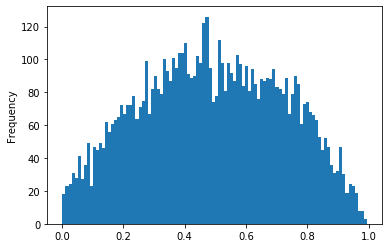

In [59]:
# See histogram of customer rank
rfm_rank_df.rfm_rank.plot.hist(bins=100)
plt.show()

## 1.2 Rank customer by C (clumpiness)

---

**Reference:** Yao Zhang & Eric T. Bradlow & Dylan S. Small, 2015. **"Predicting Customer Value Using Clumpiness: From RFM to RFMC,"** Marketing Science, INFORMS, vol. 34(2), pages 195-208, March.

In [0]:
db.query("""
WITH
    metadata AS (
        SELECT
            (SELECT MIN(trans_date) FROM retail_transaction) AS date_start
            , (SELECT MAX(trans_date) FROM retail_transaction) AS date_end
            , (SELECT JULIANDAY(MAX(trans_date)) - JULIANDAY(MIN(trans_date)) FROM retail_transaction) AS number_of_trials
    )

    , customer_event_time AS (
        SELECT 
            customer_id
            , trans_date
            , JULIANDAY(trans_date)
                 - JULIANDAY((SELECT date_start FROM metadata)) AS event_time
            , JULIANDAY(LAG(trans_date, 1) OVER (PARTITION BY customer_id ORDER BY trans_date))
                 - JULIANDAY((SELECT date_start FROM metadata)) AS lagged_event_time
        FROM retail_transaction 
        ORDER BY
            customer_id
            , trans_date
    )

    , customer_inter_event_time AS (
        SELECT 
            customer_id
            , trans_date
            , event_time
            , lagged_event_time
            , (CASE 
                WHEN lagged_event_time IS NULL THEN event_time
                WHEN lagged_event_time IS NOT NULL THEN event_time - lagged_event_time
                END) / ((SELECT number_of_trials FROM metadata) + 1)
                AS inter_event_time
        FROM customer_event_time

        UNION ALL

        -- Event time for occurence n+1
        SELECT 
            customer_id
            , (SELECT date_end FROM metadata) AS trans_date
            , (SELECT number_of_trials FROM metadata) + 1 AS event_time
            , event_time AS lagged_event_time
            , ((SELECT number_of_trials FROM metadata) + 1 - event_time)
                 / ((SELECT number_of_trials FROM metadata) + 1)
                 AS inter_event_time
        FROM customer_event_time
        WHERE 
            EXISTS (
                SELECT 1
                FROM customer_event_time t
                GROUP BY customer_id
                HAVING customer_event_time.trans_date = MAX(t.trans_date)
            )
    )

-- SELECT * FROM customer_inter_event_time
SELECT
    customer_id
    , 1 + SUM(LOG(inter_event_time, 10) * inter_event_time) / LOG(COUNT(*) + 1, 10) 
        AS clumpiness
FROM customer_inter_event_time
GROUP BY 
    customer_id
""")

In [13]:
db.query('select max(trans_date), min(trans_date) from retail_transaction')

,max(trans_date),min(trans_date)
0,2015-03-16 00:00:00,2011-05-16 00:00:00


In [33]:
import math
math.log(10, )

2.302585092994046

# 2. Segment customer

## 2.1 Segment customer by grouping customer rank

We will calculate customer rank by
- Normalize RFM by calculate percentage rank
- Take average of RFM rank

Then, we will segment customer by following groups:
- VIP: rank [8-10]
- Normal customer: rank [4-8)
- Low customer: rank [0-4)

Reference: https://phamdinhkhanh.github.io/2019/11/08/RFMModel.html

In [0]:
customer_segment_by_rfm_rank_df = db.insert_into(
    table_name = 'customer_segment_by_rfm_rank',
    query_string = 
    """
    SELECT
        customer_id
        , CASE 
            WHEN rfm_rank BETWEEN 0.8 AND 1.0 THEN 'vip'
            WHEN rfm_rank BETWEEN 0.4 AND 0.8 THEN 'normal'
            WHEN rfm_rank BETWEEN 0.0 AND 0.4 THEN 'low'
            ELSE 'unknown' END AS segment
    FROM customer_rfm_rank
    """
)
customer_segment_by_rfm_rank_df

,customer_id,segment
0,CS7638,low
1,CS8376,low
2,CS7413,low
3,CS7297,low
4,CS8753,low
...,...,...
6884,CS2338,vip
6885,CS1184,vip
6886,CS5991,vip
6887,CS4540,vip


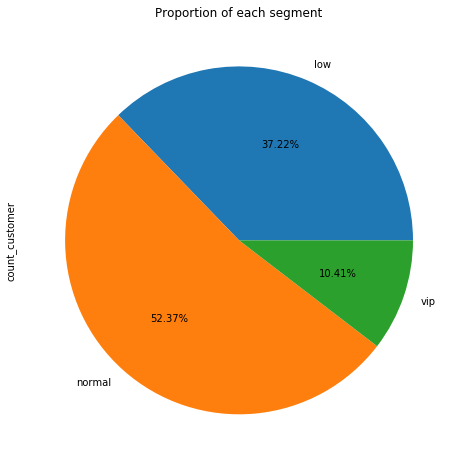

In [0]:
aggregate_by_segment = db.query(
    """
    SELECT 
        segment
        , COUNT(*) AS count_customer 
        , SUM(customer_rfm_rank.monetary) AS sum_monetary
        , AVG(customer_rfm_rank.monetary) AS avg_monetary
        , AVG(customer_rfm_rank.frequency) AS avg_frequency
        , AVG(customer_rfm_rank.recency) AS avg_recency
    FROM customer_segment_by_rfm_rank 
        LEFT JOIN customer_rfm_rank ON customer_rfm_rank.customer_id = customer_segment_by_rfm_rank.customer_id
    GROUP BY segment
    """
)
aggregate_by_segment.count_customer.plot.pie(
    labels = aggregate_by_segment.segment, 
    autopct = '%.2f%%', 
    figsize = (8, 8)
)
plt.title('Proportion of each segment')
plt.show()

The result shows that VIP customers proportion is low, only about 10%

**Recommendation**
- Increase VIP customers to 20%

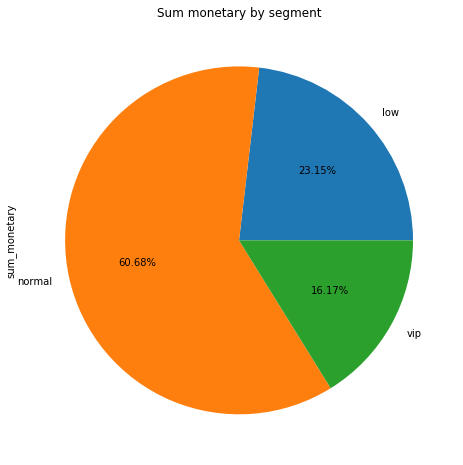

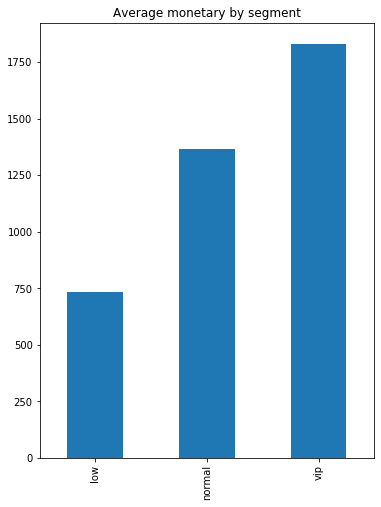

In [0]:
aggregate_by_segment.sum_monetary.plot.pie(
    labels = aggregate_by_segment.segment, 
    autopct = '%.2f%%', 
    figsize = (8, 8)
)
plt.title('Sum monetary by segment')
plt.show()

aggregate_by_segment.avg_monetary.plot.bar(figsize = (6, 8))
plt.xticks([0,1,2], aggregate_by_segment.segment)
plt.title('Average monetary by segment')
plt.show()

VIP customers should account for 80% revenue, but here only 16%.

The distance in average monetary between VIP, Normal and Low customers is small. This means the company has many potential customers.

**Recommendation**
- Increase sales from VIP customers by up-sales, cross-sales, promo
- Convert Low to Normal by promo program
- Convert Normal to VIP Customer by loyalty program


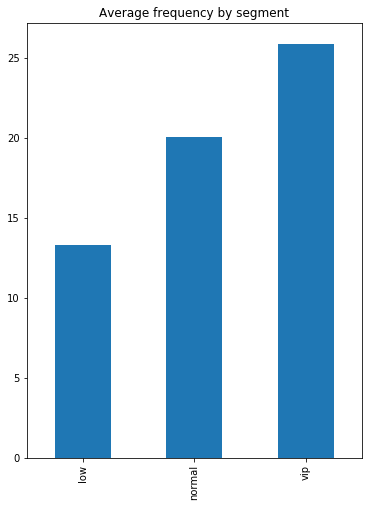

In [0]:
aggregate_by_segment.avg_frequency.plot.bar(figsize = (6, 8))
plt.xticks([0,1,2], aggregate_by_segment.segment)
plt.title('Average frequency by segment')
plt.show()

The distance in average frequency between VIP, Normal and Low customers is small.

VIP customers have both high average monetary and average frequency.

**Recommendation**
- Pay more attention to VIP Customer with loyalty program


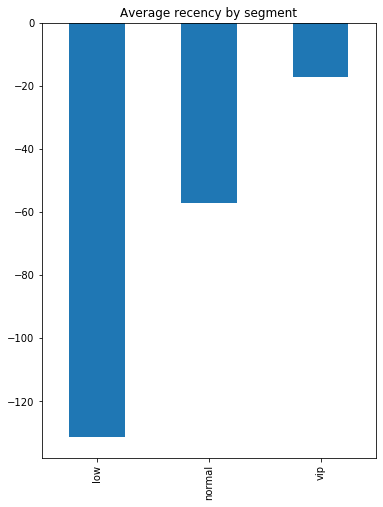

In [0]:
aggregate_by_segment.avg_recency.plot.bar(figsize = (6, 8))
plt.xticks([0,1,2], aggregate_by_segment.segment)
plt.title('Average recency by segment')
plt.show()

## 2.2 Segment customer by grouping RFM tier

We will divide customers into tiered groups for each of the three dimensions (R, F and M). 

Recency	| Frequency | Monetary
--- | --- | ---
R-Tier-1 (most recent) | F-Tier-1 (most frequent) | M-Tier-1 (highest spend)
R-Tier-2 | F-Tier-2 | M-Tier-2
R-Tier-3 | F-Tier-3 | M-Tier-3
R-Tier-4 (least recent) | F-Tier-4 (only one transaction) | M-Tier-4 (lowest spend)

The third step is to select groups of customers to whom specific types of communications will be sent, based on the RFM segments in which they appear. Marketers should assemble groups of customers most relevant for their particular business objectives and retention goals.

It is helpful to assign names to segments of interest. Here are just a few examples to illustrate:
- **Best Customers** – This group consists of those customers who are found in R-Tier-1, F-Tier-1 and M-Tier-1, meaning that they transacted recently, do so often and spend more than other customers. A shortened notation for this segment is 1-1-1; we’ll use this notation going forward.
- **High-spending New Customers** – This group consists of those customers in 1-4-1 and 1-4-2. These are customers who transacted only once, but very recently and they spent a lot.
- **Lowest-Spending Active Loyal Customers** – This group consists of those customers in segments 1-1-3 and 1-1-4 (they transacted recently and do so often, but spend the least).
- **Churned Best Customers** – This segment consists of those customers in groups 4-1-1, 4-1-2, 4-2-1 and 4-2-2 (they transacted frequently and spent a lot, but it’s been a long time since they’ve transacted).

Reference: https://www.optimove.com/resources/learning-center/rfm-segmentation

In [0]:
rfm_ntile_group_df = df(
    columns = ['recency_ntile', 'frequency_ntile', 'monetary_ntile', 'status', 'segment', 'spending'], 
    data = [
        (1, 1, 1, 'Active', 'Best', 'Normal'),
        (1, 1, 2, 'Active', 'Loyal', 'Normal'),
        (1, 1, 3, 'Active', 'Loyal', 'Low'),
        (1, 2, 1, 'Active', 'Loyal', 'Normal'),
        (1, 2, 2, 'Active', 'Normal', 'Normal'),
        (1, 2, 3, 'Active', 'Normal', 'Normal'),
        (1, 3, 1, 'Active', 'New', 'High'),
        (1, 3, 2, 'Active', 'New', 'Normal'),
        (1, 3, 3, 'Active', 'New', 'Normal'),
        (2, 1, 1, 'Churning', 'Best', 'Normal'),
        (2, 1, 2, 'Churning', 'Loyal', 'Normal'),
        (2, 1, 3, 'Churning', 'Loyal', 'Low'),
        (2, 2, 1, 'Churning', 'Loyal', 'Normal'),
        (2, 2, 2, 'Churning', 'Normal', 'Normal'),
        (2, 2, 3, 'Churning', 'Normal', 'Normal'),
        (2, 3, 1, 'Churning', 'Normal', 'High'),
        (2, 3, 2, 'Churning', 'Normal', 'Normal'),
        (2, 3, 3, 'Churning', 'Normal', 'Normal'),
        (3, 1, 1, 'Churned', 'Best', 'Normal'),
        (3, 1, 2, 'Churned', 'Loyal', 'Normal'),
        (3, 1, 3, 'Churned', 'Loyal', 'Low'),
        (3, 2, 1, 'Churned', 'Loyal', 'Normal'),
        (3, 2, 2, 'Churned', 'Normal', 'Normal'),
        (3, 2, 3, 'Churned', 'Normal', 'Normal'),
        (3, 3, 1, 'Churned', 'Normal', 'High'),
        (3, 3, 2, 'Churned', 'Normal', 'Normal'),
        (3, 3, 3, 'Churned', 'Normal', 'Normal')
    ]
)
db.create_table('rfm_ntile_group', data_df = rfm_ntile_group_df)

In [0]:
customer_segment_by_rfm_ntile_df = db.insert_into(
    table_name = 'customer_segment_by_rfm_ntile', 
    query_string = 
    """
    WITH 
        rfm_table AS (
            SELECT 
                customer_id
                , JULIANDAY(MAX(trans_date)) - JULIANDAY('now') as recency
                , COUNT(customer_id) as frequency
                , SUM(amount) as monetary
            FROM retail_transaction
            GROUP BY 
                customer_id
            ORDER BY 
                JULIANDAY(MAX(trans_date)) - JULIANDAY('now')
        )

        , customer_rfm_ntile AS (
            SELECT
                customer_id
                , recency
                , NTILE(3) OVER (ORDER BY recency DESC) as recency_ntile
                , frequency
                , NTILE(3) OVER (ORDER BY frequency DESC) as frequency_ntile
                , monetary
                , NTILE(3) OVER (ORDER BY monetary DESC) as monetary_ntile
            FROM rfm_table
        )

    SELECT
        customer_rfm_ntile.customer_id
        , customer_rfm_ntile.recency - (SELECT MAX(recency) FROM customer_rfm_ntile) as recency
        , customer_rfm_ntile.recency_ntile
        , customer_rfm_ntile.frequency
        , customer_rfm_ntile.frequency_ntile
        , customer_rfm_ntile.monetary
        , customer_rfm_ntile.monetary_ntile
        , rfm_ntile_group.status
        , rfm_ntile_group.segment
        , rfm_ntile_group.spending
    FROM customer_rfm_ntile
        LEFT JOIN rfm_ntile_group USING (recency_ntile, frequency_ntile, monetary_ntile)
    """
)
customer_segment_by_rfm_ntile_df

,customer_id,recency,recency_ntile,frequency,frequency_ntile,monetary,monetary_ntile,status,segment,spending
0,CS4608,0.0,1,32,1,2449,1,Active,Best,Normal
1,CS4540,0.0,1,32,1,2361,1,Active,Best,Normal
2,CS5991,0.0,1,29,1,1970,1,Active,Best,Normal
3,CS1184,0.0,1,28,1,1999,1,Active,Best,Normal
4,CS2338,0.0,1,27,1,2073,1,Active,Best,Normal
...,...,...,...,...,...,...,...,...,...,...
6884,CS8753,-738.0,3,11,3,497,3,Churned,Normal,Normal
6885,CS7297,-743.0,3,5,3,251,3,Churned,Normal,Normal
6886,CS7413,-765.0,3,6,3,349,3,Churned,Normal,Normal
6887,CS8376,-833.0,3,4,3,239,3,Churned,Normal,Normal


In [0]:
aggregate_by_segment = db.query(
    """
    SELECT 
        segment
        , COUNT(*) AS count_customer 
        , SUM(monetary) AS sum_monetary
        , AVG(monetary) AS avg_monetary
        , AVG(frequency) AS avg_frequency
        , AVG(recency) AS avg_recency
    FROM customer_segment_by_rfm_ntile
    GROUP BY segment
    """
)
aggregate_by_segment

,segment,count_customer,sum_monetary,avg_monetary,avg_frequency,avg_recency
0,Best,2063,3528038,1710.149297,24.157053,-55.898206
1,Loyal,468,639359,1366.151709,20.497863,-63.393162
2,New,581,404910,696.919105,12.867470,-14.106713
3,Normal,3777,3551682,940.344718,15.381255,-106.339952


In [0]:
aggregate_by_segment_status = db.query(
    """
    SELECT 
        segment
        , status
        , COUNT(*) AS count_customer 
        , SUM(monetary) AS sum_monetary
        , AVG(monetary) AS avg_monetary
        , AVG(frequency) AS avg_frequency
        , AVG(recency) AS avg_recency
    FROM customer_segment_by_rfm_ntile
    GROUP BY 
        segment
        , status
    """
)
aggregate_by_segment_status

,segment,status,count_customer,sum_monetary,avg_monetary,avg_frequency,avg_recency
0,Best,Active,860,1480463,1721.468605,24.348837,-13.777907
1,Best,Churned,444,751096,1691.657658,23.878378,-139.867117
2,Best,Churning,759,1296479,1708.140975,24.102767,-54.503294
3,Loyal,Active,185,254058,1373.286486,20.540541,-13.659459
4,Loyal,Churned,123,167261,1359.845528,20.414634,-149.292683
5,Loyal,Churning,160,218040,1362.750000,20.512500,-54.862500
6,New,Active,581,404910,696.919105,12.867470,-14.106713
7,Normal,Active,671,789256,1176.238450,18.016393,-14.509687
8,Normal,Churned,1729,1478344,855.028340,14.406593,-182.097744
9,Normal,Churning,1377,1284082,932.521423,15.320988,-55.964415


## 2.3 Segment customer by using Knn cluster
Reference: TBU

## 2.4 Further segmentation
So what should we do after segmenting our customers?
- **Customer behavior analysis** 
  - Difference in customer behavior between segments
  - Insight about customer bahavior of each segment
- **Improving your whole product:** Having a clear idea of who wants to buy your product and what they need it for will help you differentiate your company as the best solution for their individual needs. [...] allow your organization to offer better customer support, professional services, and any other offerings that make up their whole product experience.
- **Focusing your marketing message:** [...] develop more focused marketing messages that are customized to each of your best segments, resulting in higher quality inbound interest in your product.
- **Higher conversion rate:** spending less time on less lucrative opportunities and more on your most successful segments.

---

**Reference:** https://openviewpartners.com/blog/customer-segmentation
- 5 Steps to Customer Segmentation